In [39]:

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import xml.dom.minidom
from xml.dom.minidom import parse
from PIL import Image
from torchvision import transforms
from torchvision import transforms
import os
from os.path import join
import matplotlib.pyplot as plt

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class MeanShift(nn.Conv2d):
    def __init__(
        self, rgb_range,
        rgb_mean=(0.4488, 0.4371, 0.4040), rgb_std=(1.0, 1.0, 1.0), sign=-1):

        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1) / std.view(3, 1, 1, 1)
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean) / std
        for p in self.parameters():
            p.requires_grad = False

class BasicBlock(nn.Sequential):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size, stride=1, bias=False,
        bn=True, act=nn.ReLU(True)):

        m = [conv(in_channels, out_channels, kernel_size, bias=bias)]
        if bn:
            m.append(nn.BatchNorm2d(out_channels))
        if act is not None:
            m.append(act)

        super(BasicBlock, self).__init__(*m)

class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feats, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feats, n_feats, kernel_size, bias=bias))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if i == 0:
                m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feats, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feats, 4 * n_feats, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn:
                    m.append(nn.BatchNorm2d(n_feats))
                if act == 'relu':
                    m.append(nn.ReLU(True))
                elif act == 'prelu':
                    m.append(nn.PReLU(n_feats))

        elif scale == 3:
            m.append(conv(n_feats, 9 * n_feats, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if act == 'relu':
                m.append(nn.ReLU(True))
            elif act == 'prelu':
                m.append(nn.PReLU(n_feats))
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=False):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1, 1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, inpu, adj):
        support = torch.matmul(inpu, self.weight)
        #print(adj.size())
       #print(support.size())
        output = torch.matmul(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


def get_Adj(adj_file):
    import scipy.io as spio
    data = spio.loadmat(adj_file)
    data = data['FULL'].astype(np.float32)
    return data

def gen_adj(A):
    D = torch.pow(A.sum(1).float(), -0.5)
    D = torch.diag(D)
    adj = torch.matmul(torch.matmul(A, D).t(), D)
    return adj


class ResGCN(nn.Module):
    def __init__(self, features, adj):
        super(ResGCN, self).__init__()
        self.adj = adj
        self.A = nn.Parameter(torch.from_numpy(self.adj).float())
        self.relu = nn.LeakyReLU(0.2)
        self.graph_conv1 = GraphConvolution(features, features)
        self.graph_conv2 = GraphConvolution(features, features)

    def forward(self, inpu):
        adj = gen_adj(self.A).detach()
        res_g = self.graph_conv1(inpu, adj)
        res_g = self.relu(res_g)
        res_g = self.graph_conv1(res_g, adj)
        return inpu + res_g

class Deblur_model(nn.Module):
    def __init__(self, options, conv=default_conv):
        super(Deblur_model, self).__init__()
        #Typically, it needs 2 downsample layers for deblurring
        n_resblocks = int(options.getElementsByTagName('n_resblocks')[0].childNodes[0].nodeValue)  #number of resblocks is each stage
        n_filters = int(options.getElementsByTagName('n_filters')[0].childNodes[0].nodeValue)
        n_graph_features = int(options.getElementsByTagName('n_graph_features')[0].childNodes[0].nodeValue)
        n_graph_layers = int(options.getElementsByTagName('n_graph_layers')[0].childNodes[0].nodeValue)
        kernel_size = 3 
        act = nn.ReLU(True)
        #OneDrive/Desktop/CV/GCResNet/Adj_matrix/deblur_2_full.mat
        adj_dir = os.path.join(folder_path,r'deblur_2_full.mat')
        n_ResGCN = int(options.getElementsByTagName('n_ResGCN')[0].childNodes[0].nodeValue)
        rgb_range = 255
        n_colors = 3

        self.sub_mean = MeanShift(rgb_range)
        self.add_mean = MeanShift(rgb_range, sign=1)

        # define head module
        m_head = [conv(n_colors, n_filters, kernel_size)]

        # define body module 
        # encoder_1 -> encoder_2 -> encoder_3 -> GNN -> decoder_3 -> decoder_2 -> decoder_1
        encoder_1 = [ResBlock(conv, n_filters, 
                kernel_size, act=act, res_scale=1) for _ in range(n_resblocks)]
        self.downsample_1 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=2, padding=1)

        encoder_2 = [ResBlock(conv, n_filters, 
                kernel_size, act=act, res_scale=1) for _ in range(n_resblocks)]
        self.downsample_2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=2, padding=1)

        encoder_3 = [ResBlock(conv, n_filters, 
                kernel_size, act=act, res_scale=1) for _ in range(n_resblocks)]
        self.downsample_graph = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=10, padding=1)


        _adj = get_Adj(adj_file=adj_dir)
        self.A = nn.Parameter(torch.from_numpy(_adj).float())


        GCN_body = [
            ResGCN(
                n_graph_features, _adj
            ) for _ in range(n_ResGCN)
        ]
        self.graph_convhead = GraphConvolution(1, n_graph_features)
        self.graph_convtail = GraphConvolution(n_graph_features, 1)


        self.upsample_graph = nn.ConvTranspose2d(n_filters, n_filters, kernel_size=kernel_size, stride=10, padding=1, output_padding=9)
        decoder_3 = [ResBlock(conv, n_filters, 
                kernel_size, act=act, res_scale=1) for _ in range(n_resblocks)]

        self.upsample_2 = nn.ConvTranspose2d(n_filters, n_filters, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)
        decoder_2 = [ResBlock(conv, n_filters, 
                kernel_size, act=act, res_scale=1) for _ in range(n_resblocks)]

        self.upsample_1 = nn.ConvTranspose2d(n_filters, n_filters, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)
        decoder_1 = [ResBlock(conv, n_filters, 
                kernel_size, act=act, res_scale=1) for _ in range(n_resblocks)]


        # define tail module
        m_tail = [conv(n_filters, n_colors, kernel_size)]

        self.relu = nn.LeakyReLU(0.2)
        self.head = nn.Sequential(*m_head)
        self.encoder_1 = nn.Sequential(*encoder_1)
        self.encoder_2 = nn.Sequential(*encoder_2)
        self.encoder_3 = nn.Sequential(*encoder_3)
        self.GCN_body = nn.Sequential(*GCN_body)

        #self.graph_conv = nn.Sequential(*graph_conv)
        self.decoder_3 = nn.Sequential(*decoder_3)
        self.decoder_2 = nn.Sequential(*decoder_2)
        self.decoder_1 = nn.Sequential(*decoder_1)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
        #res = self.sub_mean(x)
        res = self.head(x)

        res_enc1 = self.encoder_1(res)
        res_down1 = self.downsample_1(res_enc1)
        res_enc2 = self.encoder_2(res_down1)
        res_down2 = self.downsample_2(res_enc2)
        res_enc3 = self.encoder_3(res_down2)
        yin = self.downsample_graph(res_enc3)

        yin = yin.permute(0,2,3,1)
        yin = yin.unsqueeze(4)
        #print(yin.size())

        adj = gen_adj(self.A).detach()
        #print(adj.size())
        res_g = self.graph_convhead(yin, adj) #make(yin, adj) as dict to let it available in nn.Sequential
        res_g = self.GCN_body(res_g)
        res_g = self.graph_convtail(res_g, adj)
        res_g = self.relu(res_g)

        res_g = res_g.squeeze(4)
        yout = res_g.permute(0,3,1,2)


        res_up3 = self.upsample_graph(yout)
        res_dec3 = self.decoder_3(res_up3 + res_enc3)
        res_up2 = self.upsample_2(res_dec3)
        res_dec2 = self.decoder_2(res_up2 + res_enc2)
        res_up1 = self.upsample_1(res_dec2)
        res_out = self.decoder_1(res_up1 + res_enc1)

        res = self.tail(res_out)
        #res = self.add_mean(res)

        res += x
        return res

    def load_state_dict(self, state_dict, strict=True):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') == -1:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))

In [3]:
folder_path = r'./'
dataset = 'GoPro'

if dataset == 'GoPro':
    model_path = os.path.join(folder_path,r'model_deblur_gopro.pt')
elif dataset == 'HIDE':
    model_path = os.path.join(folder_path,r'model_deblur_hide.pt')

Images ['0001.png', '0812.png', '1012.png', '1063.png']
(320, 200)
(320, 200)
(320, 200)


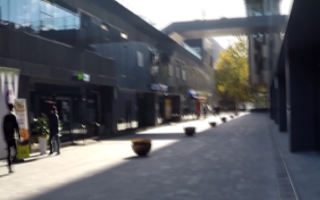

In [19]:
imgs_folder = r"D:\Git_repos2\CS6350\test_images"
lr_images_folder = join(imgs_folder, "LR")
hr_images_folder = join(imgs_folder, "LR_gt")

img_names = os.listdir(lr_images_folder)
print("Images", img_names)
i = 3
img_name = img_names[i]

img_path = os.path.join(lr_images_folder, img_name)
img = Image.open(img_path)
img = img.resize((320,200))
print(img.size)
hr_img_path = os.path.join(hr_images_folder, img_name)
hr_img = Image.open(hr_img_path)
hr_img = hr_img.resize((320,200))
print(hr_img.size)

print(hr_img.size)
img

In [50]:
option_file = parse(os.path.join(folder_path,r'options.xml'))
options = option_file.getElementsByTagName("options")[0]

test_model = Deblur_model(options)
test_model.load_state_dict(torch.load(os.path.join(folder_path,r'model_deblur_gopro.pt'),map_location=torch.device('cpu')))
test_model.eval()

tfms = transforms.Compose([
        transforms.ToTensor(),])  

def img_to_tensor(img):
    img_tensor = tfms(img).unsqueeze(0)
    return img_tensor

a = test_model(img_to_tensor(img))

import imageio
#print(a)
#torch.save(a,os.path.join(folder_path,'abc.pt'))
import skimage.metrics as metrics
b1 = np.squeeze(a.detach().numpy()).transpose(1,2,0)
b = b1.clip(0,1)*255
b = b.astype(np.uint8)
print(b.shape)
c = np.squeeze(np.array(hr_img))
print(c.shape)
print(metrics.peak_signal_noise_ratio(c,b))
print(metrics.structural_similarity(c,b,multichannel = True))

(200, 320, 3)
(200, 320, 3)
12.682058519177087
0.3399154253811014


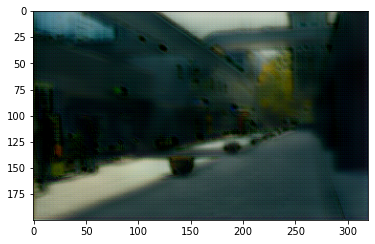

In [48]:
plt.imshow(b)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


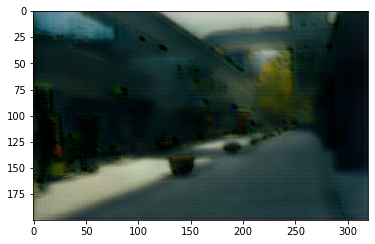

In [51]:
plt.imshow(b1)

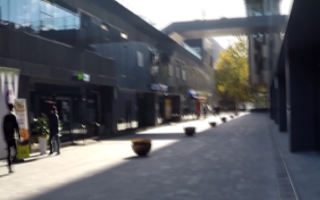

In [49]:
img